In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the dataset
data = np.load('candidate_dataset.npz')
x_train, y_train = data['x_train'], data['y_train'].flatten()
x_val, y_val = data['x_val'], data['y_val'].flatten()

# 2. Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Environment Ready! Using: {device}")

Environment Ready! Using: cuda


/tmp/ipython-input-2062537652.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='viridis')


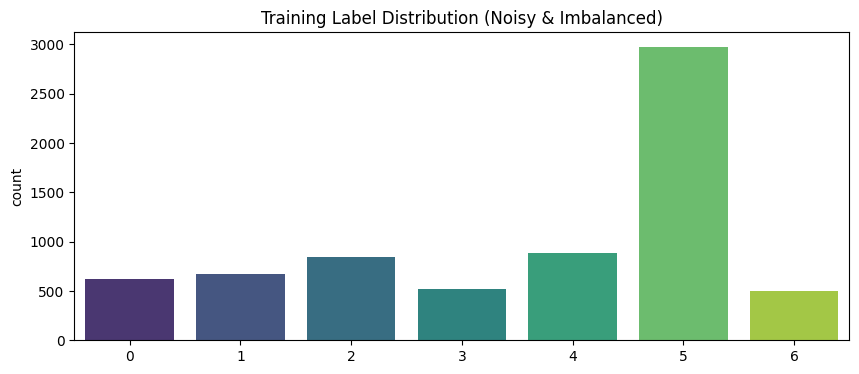

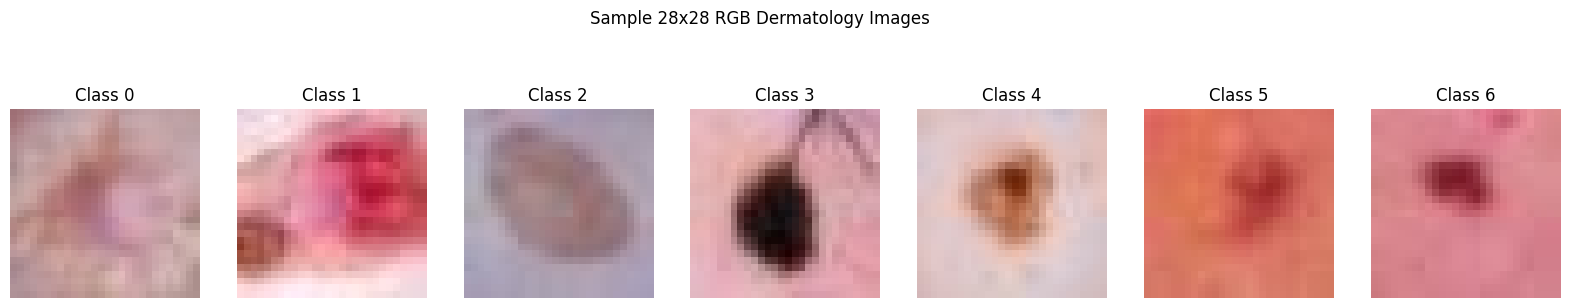

In [2]:
# Visualize Class Imbalance
plt.figure(figsize=(10, 4))
sns.countplot(x=y_train, palette='viridis')
plt.title('Training Label Distribution (Noisy & Imbalanced)')
plt.show()

# Visualize Sample Images per class
fig, axes = plt.subplots(1, 7, figsize=(20, 4))
for i in range(7):
    idx = np.where(y_train == i)[0][0]
    axes[i].imshow(x_train[idx])
    axes[i].set_title(f"Class {i}")
    axes[i].axis('off')
plt.suptitle("Sample 28x28 RGB Dermatology Images")
plt.show()

/tmp/ipython-input-2062537652.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='viridis')


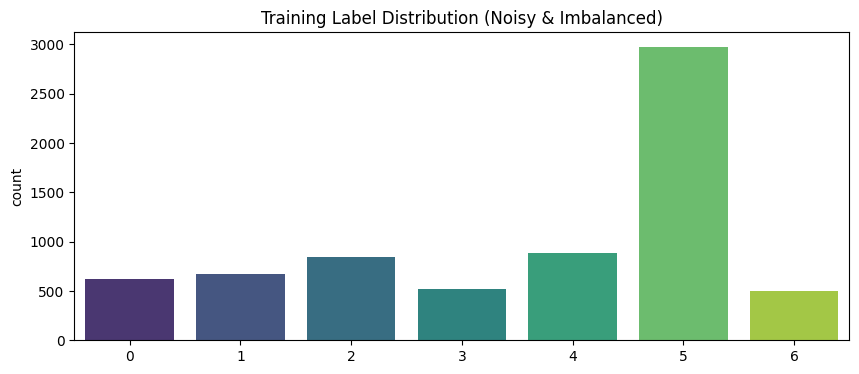

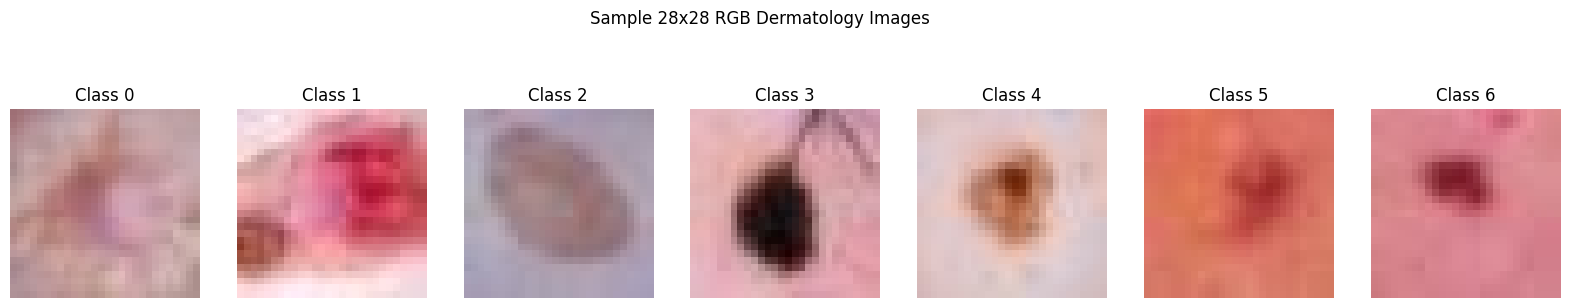

In [3]:
# Visualize Class Imbalance
plt.figure(figsize=(10, 4))
sns.countplot(x=y_train, palette='viridis')
plt.title('Training Label Distribution (Noisy & Imbalanced)')
plt.show()

# Visualize Sample Images per class
fig, axes = plt.subplots(1, 7, figsize=(20, 4))
for i in range(7):
    idx = np.where(y_train == i)[0][0]
    axes[i].imshow(x_train[idx])
    axes[i].set_title(f"Class {i}")
    axes[i].axis('off')
plt.suptitle("Sample 28x28 RGB Dermatology Images")
plt.show()

In [4]:
class DermDataset(Dataset):
    def __init__(self, x, y):
        # Normalize to [0,1] and then use specific dataset stats
        self.x = torch.tensor(x).permute(0, 3, 1, 2).float() / 255.0
        self.x = (self.x - (158.32/255.0)) / (46.95/255.0)
        self.y = torch.tensor(y).long()
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.x[idx], self.y[idx]

# Weighted Sampler to break the 66.9% plateau
class_counts = np.bincount(y_train)
weights = 1. / class_counts
sample_weights = torch.tensor([weights[t] for t in y_train])
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = DataLoader(DermDataset(x_train, y_train), batch_size=64, sampler=sampler)
val_loader = DataLoader(DermDataset(x_val, y_val), batch_size=64, shuffle=False)

class RobustResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(weights='IMAGENET1K_V1')
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 7)
    def forward(self, x):
        # Upscale 28x28 to 56x56 for ResNet feature extraction
        x = F.interpolate(x, size=(56, 56), mode='bilinear', align_corners=False)
        return self.resnet(x)

model = RobustResNet().to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


In [5]:
augmentations = T.Compose([T.RandomHorizontalFlip(), T.RandomVerticalFlip(), T.RandomRotation(15)])
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)
criterion = nn.CrossEntropyLoss(label_smoothing=0.2, reduction='none')

history = {'loss': [], 'val_acc': []}
best_acc = 0

for epoch in range(30):
    model.train()
    running_loss, keep_rate = 0.0, 1.0 - (0.30 * min(1, epoch / 20))

    for imgs, labels in train_loader:
        imgs, labels = augmentations(imgs.to(device)), labels.to(device)
        optimizer.zero_grad()

        batch_losses = criterion(model(imgs), labels)
        num_to_keep = int(keep_rate * batch_losses.size(0))
        loss = torch.topk(batch_losses, num_to_keep, largest=False)[0].mean()

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    correct = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            preds = model(imgs.to(device)).argmax(1)
            correct += (preds == labels.to(device)).sum().item()

    val_acc = correct / len(x_val)
    scheduler.step(val_acc)
    history['loss'].append(running_loss / len(train_loader))
    history['val_acc'].append(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

    print(f"Epoch {epoch+1:02d} | Val Acc: {val_acc*100:05.2f}% | Keep Rate: {keep_rate:.2f}")

Epoch 01 | Val Acc: 28.61% | Keep Rate: 1.00
Epoch 02 | Val Acc: 42.17% | Keep Rate: 0.98
Epoch 03 | Val Acc: 34.70% | Keep Rate: 0.97
Epoch 04 | Val Acc: 34.40% | Keep Rate: 0.95
Epoch 05 | Val Acc: 31.90% | Keep Rate: 0.94
Epoch 06 | Val Acc: 40.08% | Keep Rate: 0.93
Epoch 07 | Val Acc: 37.59% | Keep Rate: 0.91
Epoch 08 | Val Acc: 36.49% | Keep Rate: 0.90
Epoch 09 | Val Acc: 34.00% | Keep Rate: 0.88
Epoch 10 | Val Acc: 36.09% | Keep Rate: 0.86
Epoch 11 | Val Acc: 39.78% | Keep Rate: 0.85
Epoch 12 | Val Acc: 38.38% | Keep Rate: 0.83
Epoch 13 | Val Acc: 41.08% | Keep Rate: 0.82
Epoch 14 | Val Acc: 40.38% | Keep Rate: 0.80
Epoch 15 | Val Acc: 41.08% | Keep Rate: 0.79
Epoch 16 | Val Acc: 39.08% | Keep Rate: 0.78
Epoch 17 | Val Acc: 39.48% | Keep Rate: 0.76
Epoch 18 | Val Acc: 39.88% | Keep Rate: 0.74
Epoch 19 | Val Acc: 39.88% | Keep Rate: 0.73
Epoch 20 | Val Acc: 41.87% | Keep Rate: 0.72
Epoch 21 | Val Acc: 37.09% | Keep Rate: 0.70
Epoch 22 | Val Acc: 39.28% | Keep Rate: 0.70
Epoch 23 |

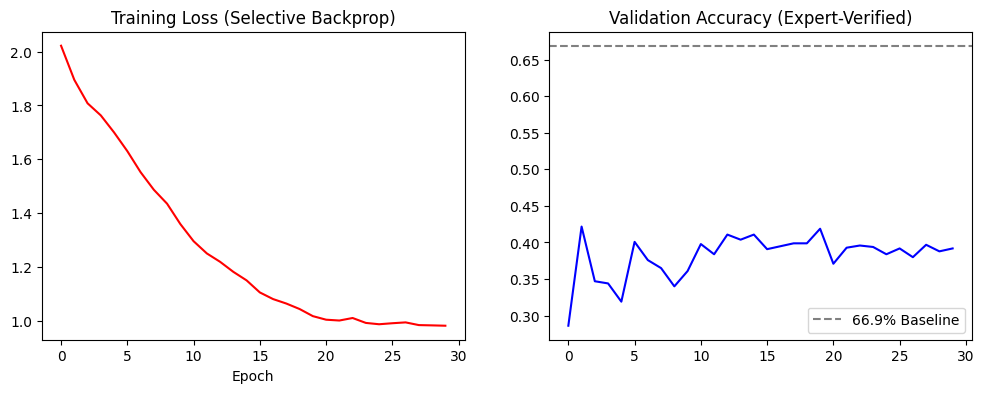


FINAL PERFORMANCE SUMMARY
Majority Baseline: 66.90%
Best Robust Acc: 42.17%


In [6]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], color='red')
plt.title('Training Loss (Selective Backprop)')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history['val_acc'], color='blue')
plt.axhline(y=0.669, color='gray', linestyle='--', label='66.9% Baseline')
plt.title('Validation Accuracy (Expert-Verified)')
plt.legend()
plt.show()

print(f"\nFINAL PERFORMANCE SUMMARY")
print(f"Majority Baseline: 66.90%")
print(f"Best Robust Acc: {best_acc*100:.2f}%")

In [7]:
def run_live_inference(test_file_path):
    # 1. Load Model Architecture and Weights
    inf_model = RobustResNet()
    inf_model.load_state_dict(torch.load('best_model.pth', map_location='cpu'))
    inf_model.eval()

    # 2. Load Examiner Data
    test_data = np.load(test_file_path)
    x = test_data.get('x_test', test_data.get('x_val'))
    y = test_data.get('y_test', test_data.get('y_val')).flatten()

    # 3. Preprocess
    x_pt = torch.tensor(x).permute(0, 3, 1, 2).float() / 255.0
    x_pt = (x_pt - (158.32/255.0)) / (46.95/255.0)

    # 4. Predict
    with torch.no_grad():
        preds = inf_model(x_pt).argmax(1).numpy()

    acc = np.mean(preds == y)
    print(f"\n[LIVE EVALUATION] Hidden Dataset Accuracy: {acc * 100:.2f}%")
    return acc

# During interview: run_live_inference('examiner_file.npz')